# Classification model on Cardiotocography dataset

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.regularizers import l2
import multiprocessing as mp
from time import time


import os
if not os.path.isdir('figures'):
    os.makedirs('figures')

## Set parameters
The number of hidden neurons is not initialized here as it will be tested later.

In [2]:
lr = 0.01
no_folds = 5
no_epochs = 1000
batch_size = 64
beta = 0.000001

NO_INPUTS = 21
NO_CLASSES = 3


seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

## Read data

In [3]:
# read in data from csv file
df = pd.read_csv('ctg_data_cleaned.csv')
df=df.values

In [4]:
# data
# generate training data from csv file

# inputs are the first 21 columns
X = df[:,0:21]
# normalizing every input
max_arr = np.max(X, axis = 0)
min_arr = np.min(X, axis = 0)
for i in range(2126):
    for j in range(21):
        X[i,j] = (X[i,j] - min_arr[j])/(max_arr[j] - min_arr[j])

# target is the last column
Y = df[:,22]
# convert [1,2,3] to [0,1,2] as class label starts from 0
Y -= 1
Y = Y.reshape(2126,1).astype(int)

# split training and testing sets (70/30)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 42) 

## Implement 5-cross validation
Use 5-cross validation to determine the best number of hidden neurons. The number of hidden neurons should be passed in as a parameter.

In [5]:
# number of patterns in each fold
nf = len(x_train)//no_folds

def train(no_neurons):
    # min and max value for weight initialization
    w_min_relu = -np.sqrt(6)/np.sqrt(NO_INPUTS+no_neurons)
    w_max_relu = np.sqrt(6)/np.sqrt(NO_INPUTS+no_neurons)
    w_min_softmax = -4*np.sqrt(6)/np.sqrt(no_neurons+NO_CLASSES)
    w_max_softmax = 4*np.sqrt(6)/np.sqrt(no_neurons+NO_CLASSES)
    
    acc_matrix = np.zeros((no_folds,no_epochs)) 
    total_time = 0
    for fold in range(no_folds):
        start, end = fold*nf, (fold+1)*nf
        # Set the end index for the last fold to cover all training data
        if fold == 4:
            end == 1488
        
        x_train_test, y_train_test = x_train[start:end], y_train[start:end]
        x_train_train  = np.append(x_train[:start], x_train[end:], axis=0)
        y_train_train = np.append(y_train[:start], y_train[end:], axis=0) 
        
        model = Sequential([Dense(no_neurons, activation='relu', 
                          kernel_initializer=RandomUniform(w_min_relu, w_max_relu), 
                          kernel_regularizer=l2(beta)),
                    Dense(NO_CLASSES, activation='softmax', 
                          kernel_initializer=RandomUniform(w_min_softmax, w_max_softmax),
                          kernel_regularizer=l2(beta))])
        
        model.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
        
        startTime = time()
        history = model.fit(x_train_train, y_train_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=0,
                    use_multiprocessing=True,
                    validation_data=(x_train_test, y_train_test))
        total_time += time()-startTime
        
        for i in range (no_epochs):
            acc_matrix[fold,:] = history.history['val_accuracy']

    acc = np.mean(acc_matrix, axis = 0)
    epoch_time = total_time/(no_folds*no_epochs)
    return acc, epoch_time

    


## Compare performance
Using batch size = 5, 10, 15, 20, 25, print the accuracies and execution time.

In [6]:
acc_5,epoch_time_5 = train(5)
acc_10, epoch_time_10 = train(10)
acc_15, epoch_time_15 = train(15)
acc_20, epoch_time_20 = train(20)
acc_25, epoch_time_25 = train(25)

In [7]:
print('The cross-validation accuracy of 5 hidden neurons is: %g' %acc_5[no_epochs - 1])
print('The cross-validation accuracy of 10 hidden neurons is: %g' %acc_10[no_epochs - 1])
print('The cross-validation accuracy of 15 hidden neurons is: %g' %acc_15[no_epochs - 1])
print('The cross-validation accuracy of 20 hidden neurons is: %g' %acc_20[no_epochs - 1])
print('The cross-validation accuracy of 25 hidden neurons is: %g' %acc_25[no_epochs - 1])

The cross-validation accuracy of 5 hidden neurons is: 0.892929
The cross-validation accuracy of 10 hidden neurons is: 0.893603
The cross-validation accuracy of 15 hidden neurons is: 0.890909
The cross-validation accuracy of 20 hidden neurons is: 0.893603
The cross-validation accuracy of 25 hidden neurons is: 0.886869


In [8]:
print('The training time for one epoch of 5 hidden neurons is: %g' %epoch_time_5)
print('The training time for one epoch of 10 hidden neurons is: %g' %epoch_time_10)
print('The training time for one epoch of 15 hidden neurons is: %g' %epoch_time_15)
print('The training time for one epoch of 20 hidden neurons is: %g' %epoch_time_20)
print('The training time for one epoch of 25 hidden neurons is: %g' %epoch_time_25)

The training time for one epoch of 5 hidden neurons is: 0.0360102
The training time for one epoch of 10 hidden neurons is: 0.0371967
The training time for one epoch of 15 hidden neurons is: 0.0376602
The training time for one epoch of 20 hidden neurons is: 0.0372887
The training time for one epoch of 25 hidden neurons is: 0.0375375


## Plot accuracy and time curves

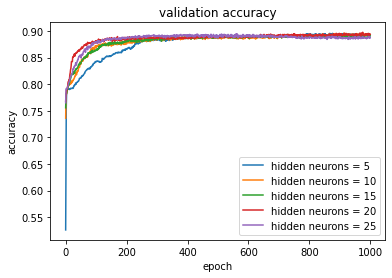

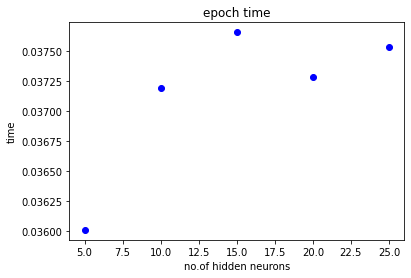

In [9]:
# summarize history for accuracy
plt.plot(acc_5)
plt.plot(acc_10)
plt.plot(acc_15)
plt.plot(acc_20)
plt.plot(acc_25)
plt.title('validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['hidden neurons = 5', 'hidden neurons = 10', 'hidden neurons = 15', 'hidden neurons = 20', 'hidden neurons = 25'], loc='lower right')
plt.savefig("3aAcc.png")
plt.show()

# summarize epoch time
plt.plot(5, epoch_time_5, 'bo')
plt.plot(10, epoch_time_10,'bo')
plt.plot(15, epoch_time_15, 'bo')
plt.plot(20, epoch_time_20, 'bo')
plt.plot(25, epoch_time_25, 'bo')
plt.title('epoch time')
plt.ylabel('time')
plt.xlabel('no.of hidden neurons')
plt.savefig("3aTime.png")
plt.show()

